In [32]:
%autosave 10

Autosaving every 10 seconds


https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html

In [2]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
from dask.distributed import Client
import dask.dataframe as dd

import datetime as dt
import urllib
import ssl
import io
import os

dask_client = Client()

In [3]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['xtick.direction'] = 'out'

change_plot_size(20, 6, plt)

In [5]:
colnames = ['drum pressure',
            'excess oxygen',
            'water level',
            'steam flow'
           ]

context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
url = 'https://www.cs.ucr.edu/~eamonn/iSAX/steamgen.dat'
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
steam_df = pd.read_csv(data, header=None, sep="\\s+")
steam_df.columns = colnames
steam_df.head()

drum pressure  excess oxygen  water level  steam flow
0      320.08239       2.506774     0.032701    9.302970
1      321.71099       2.545908     0.284799    9.662621
2      320.91331       2.360562     0.203652   10.990955
3      325.00252       0.027054     0.326187   12.430107
4      326.65276       0.285649     0.753776   13.681666

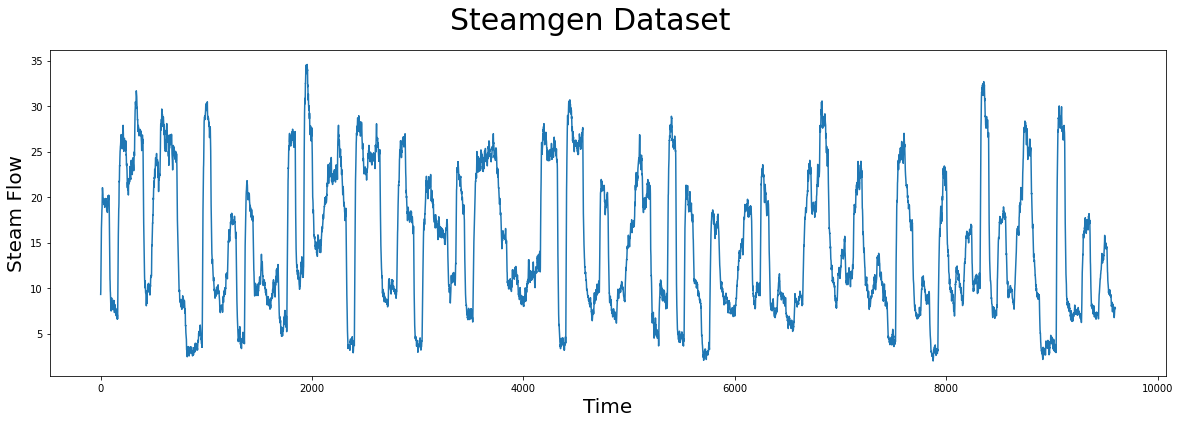

In [6]:
plt.suptitle('Steamgen Dataset', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(steam_df['steam flow'].values)

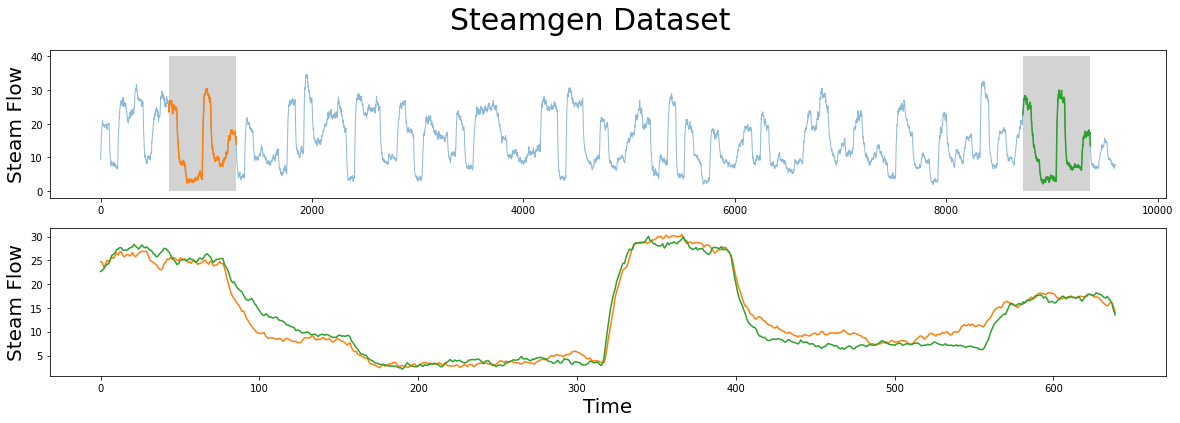

In [7]:
m = 640
fig, axs = plt.subplots(2)
plt.suptitle('Steamgen Dataset', fontsize='30')
axs[0].set_ylabel("Steam Flow", fontsize='20')
axs[0].plot(steam_df['steam flow'], alpha=0.5, linewidth=1)
axs[0].plot(steam_df['steam flow'].iloc[643:643+m])
axs[0].plot(steam_df['steam flow'].iloc[8724:8724+m])
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='20')
axs[1].plot(steam_df['steam flow'].values[643:643+m], color='C1')
axs[1].plot(steam_df['steam flow'].values[8724:8724+m], color='C2')

In [8]:
m = 640
mp = stumpy.stumped(dask_client, steam_df['steam flow'], m)

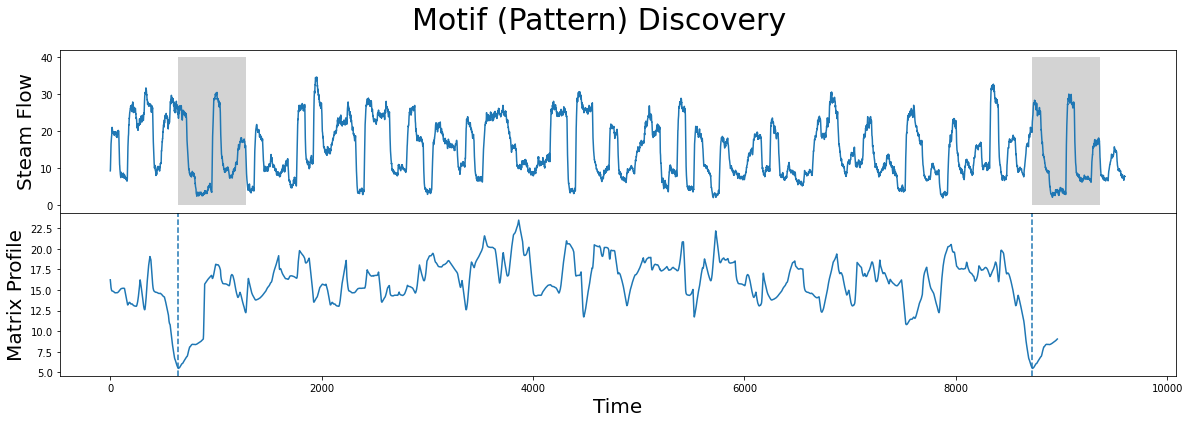

In [9]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=643, linestyle="dashed")
axs[1].axvline(x=8724, linestyle="dashed")
axs[1].plot(mp[:, 0])

In [10]:
mp[:, 0].min()

5.491619827769512

In [11]:
mp[:, 0].max()

23.47616836730203

In [12]:
np.argwhere(mp[:, 0] == mp[:, 0].max()).flatten()[0]

3864

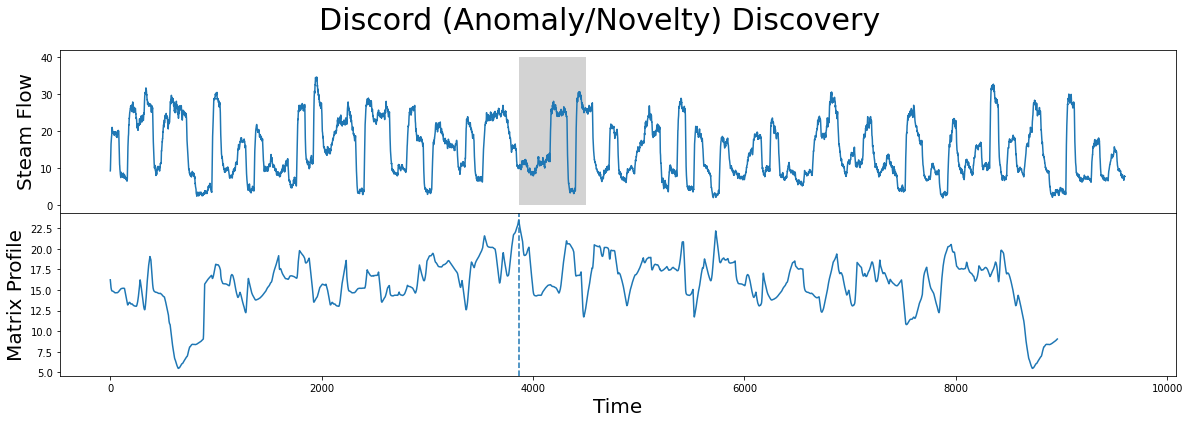

In [16]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='30')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((3864, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=3864, linestyle="dashed")
axs[1].plot(mp[:, 0])

NYC Taxis passengers

In [17]:
taxi_df = pd.read_csv("https://raw.githubusercontent.com/stanford-futuredata/ASAP/master/Taxi.csv", sep=',')
taxi_df['value'] = taxi_df['value'].astype(np.float64)
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df.head()

timestamp    value
0 2014-10-01 00:00:00  12751.0
1 2014-10-01 00:30:00   8767.0
2 2014-10-01 01:00:00   7005.0
3 2014-10-01 01:30:00   5257.0
4 2014-10-01 02:00:00   4189.0

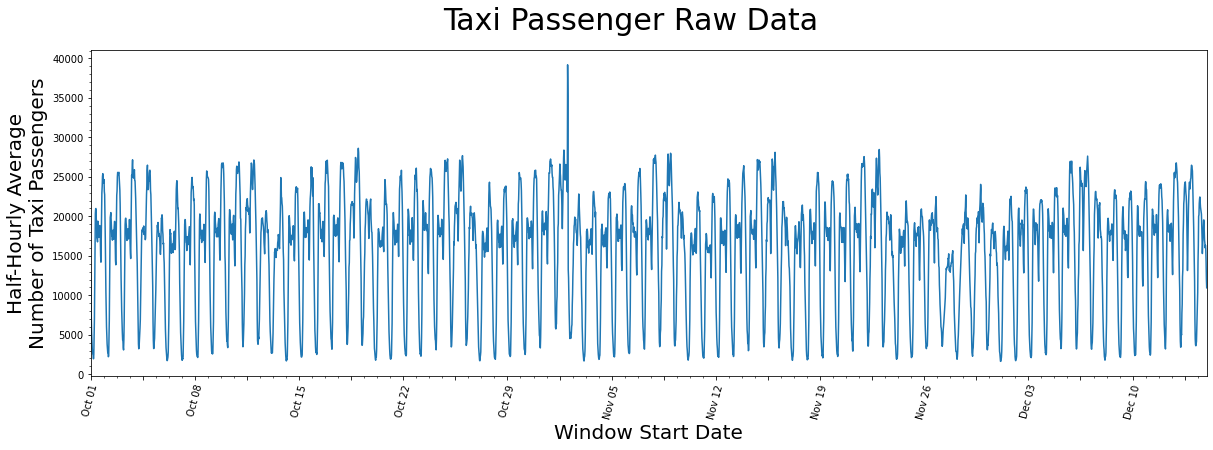

In [18]:
# This code is going to be utilized to control the axis labeling of the plots
DAY_MULTIPLIER = 7  # Specify for the amount of days you want between each labeled x-axis tick

x_axis_labels = taxi_df[(taxi_df.timestamp.dt.hour==0)]['timestamp'].dt.strftime('%b %d').values[::DAY_MULTIPLIER]
x_axis_labels[1::2] = " "
x_axis_labels, DAY_MULTIPLIER

plt.suptitle('Taxi Passenger Raw Data', fontsize='30')
plt.xlabel('Window Start Date', fontsize ='20')
plt.ylabel('Half-Hourly Average\nNumber of Taxi Passengers', fontsize='20')
plt.plot(taxi_df['value'])

plt.xticks(np.arange(0, taxi_df['value'].shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.margins(x=0)
plt.show()

In [19]:
# data is half-hourly, so m=48 is 1 day
m = 48
mp = stumpy.stumped(dask_client, taxi_df['value'], m=m)

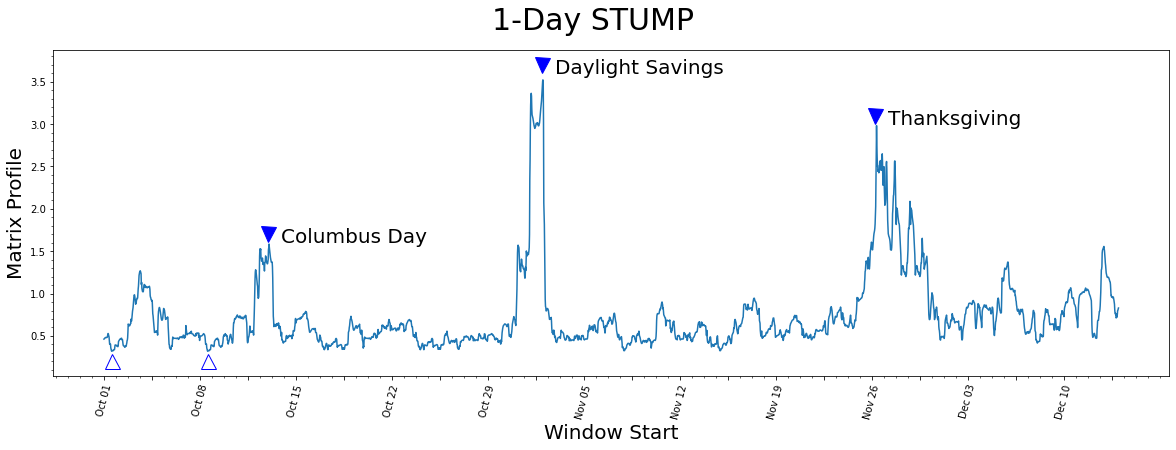

In [20]:
plt.suptitle('1-Day STUMP', fontsize='30')
plt.xlabel('Window Start', fontsize ='20')
plt.ylabel('Matrix Profile', fontsize='20')
plt.plot(mp[:, 0])

plt.plot(575, 1.7, marker="v", markersize=15, color='b')
plt.text(620, 1.6, 'Columbus Day', color="black", fontsize=20)
plt.plot(1535, 3.7, marker="v", markersize=15, color='b')
plt.text(1580, 3.6, 'Daylight Savings', color="black", fontsize=20)
plt.plot(2700, 3.1, marker="v", markersize=15, color='b')
plt.text(2745, 3.0, 'Thanksgiving', color="black", fontsize=20)
plt.plot(30, .2, marker="^", markersize=15, color='b', fillstyle='none')
plt.plot(363, .2, marker="^", markersize=15, color='b', fillstyle='none')
plt.xticks(np.arange(0, 3553, (m*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.show()

In [21]:
days_dict ={
  "Half-Day": 24,
  "1-Day": 48,
  "2-Days": 96,
  "5-Days": 240,
  "7-Days": 336,
}

days_df = pd.DataFrame.from_dict(days_dict, orient='index', columns=['m'])
days_df.head()

m
Half-Day   24
1-Day      48
2-Days     96
5-Days    240
7-Days    336

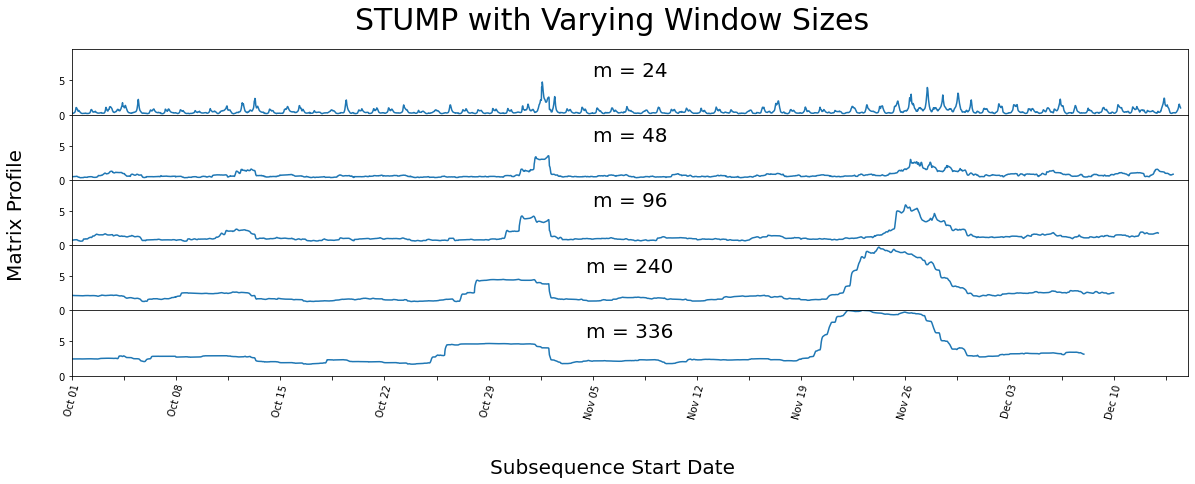

In [24]:
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={'hspace': 0})
fig.text(0.5, -0.1, 'Subsequence Start Date', ha='center', fontsize='20')
fig.text(0.08, 0.5, 'Matrix Profile', va='center', rotation='vertical', fontsize='20')
for i, varying_m in enumerate(days_df['m'].values):
    mp = stumpy.stump(taxi_df['value'], varying_m)
    axs[i].plot(mp[:, 0])
    axs[i].set_ylim(0,9.5)
    axs[i].set_xlim(0,3600)
    title = f"m = {varying_m}"
    axs[i].set_title(title, fontsize=20, y=.5)
plt.xticks(np.arange(0, taxi_df.shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.suptitle('STUMP with Varying Window Sizes', fontsize='30')
plt.show()

### Time Series Chains

https://stumpy.readthedocs.io/en/latest/Tutorial_Time_Series_Chains.html

In [25]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import urllib
import ssl
import io
import itertools

In [26]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size

change_plot_size(20, 6, plt)

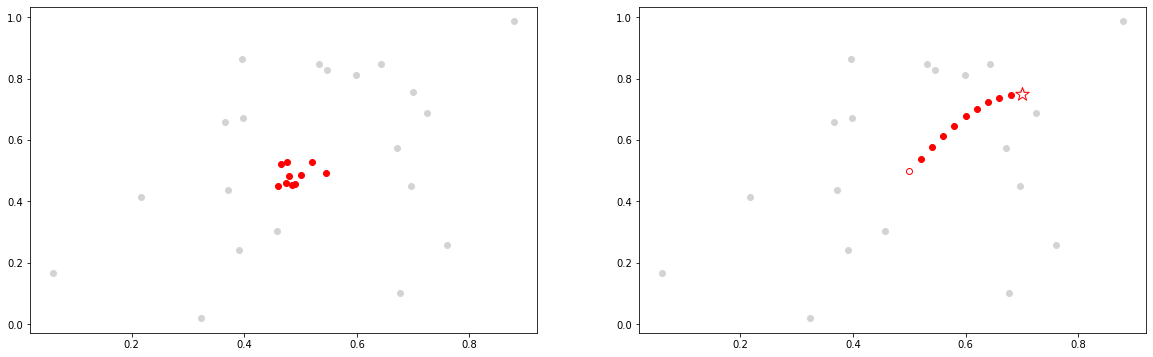

In [27]:
x = np.random.rand(20)
y = np.random.rand(20)
n = 10
motifs_x = 0.5 * np.ones(n) + np.random.uniform(-0.05, 0.05, n)
motifs_y = 0.5 * np.ones(n) + np.random.uniform(-0.05, 0.05, n)
sin_x = np.linspace(0, np.pi/2, n+1)
sin_y = np.sin(sin_x)/4
chains_x = 0.5 * np.ones(n+1) + 0.02 * np.arange(n+1)
chains_y = 0.5 * np.ones(n+1) + sin_y
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].scatter(x, y, color='lightgrey')
axes[0].scatter(motifs_x, motifs_y, color='red')
axes[1].scatter(x, y, color='lightgrey')
axes[1].scatter(chains_x[0], chains_y[0], edgecolor='red', color='white')
axes[1].scatter(chains_x[1:n], chains_y[1:n], color='red')
axes[1].scatter(chains_x[n], chains_y[n], edgecolor='red', color='white', marker='*', s=200)


In [30]:
context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
url = 'https://sites.google.com/site/timeserieschain/home/Kohls_data.mat?attredirects=0&revision=1'
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
mat = loadmat(data)
mdata = mat['VarName1']
mdtype = mdata.dtype

df = pd.DataFrame(mdata, dtype=mdtype, columns=['volume'])
df.describe()

volume
count  550.000000
mean     0.192235
std      0.140036
min      0.000000
25%      0.093750
50%      0.156250
75%      0.291667
max      1.000000

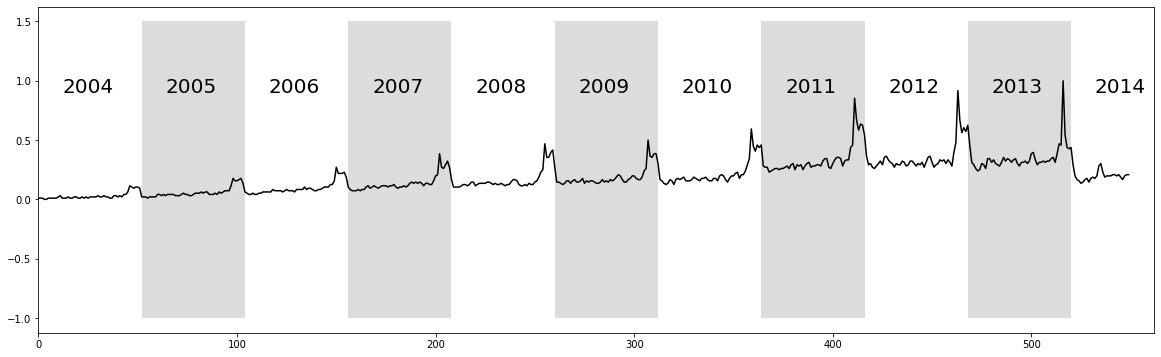

In [31]:
plt.plot(df['volume'], color='black')
plt.xlim(0, df.shape[0]+12)
color = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, df.shape[0], 52)):
    plt.text(x+12, 0.9, str(2004+i), color="black", fontsize=20)
    rect = Rectangle((x, -1), 52, 2.5, facecolor=next(color))
    plt.gca().add_patch(rect)

In [33]:
?stumpy.stump

In [34]:
m = 20
mp = stumpy.stump(df['volume'], m=m)

In [35]:
all_chain_set, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])

In [38]:
all_chain_set

[array([ 45,  97, 149]),
 array([319]),
 array([175]),
 array([184]),
 array([207, 259, 311, 468]),
 array([431]),
 array([13]),
 array([22]),
 array([31]),
 array([  5, 213]),
 array([278]),
 array([283, 335, 387, 439, 491]),
 array([258, 310, 467]),
 array([417]),
 array([426]),
 array([8]),
 array([17]),
 array([26]),
 array([264]),
 array([273]),
 array([ 57, 110, 158]),
 array([291]),
 array([ 68, 120]),
 array([156]),
 array([  4, 212]),
 array([165]),
 array([412]),
 array([168, 481]),
 array([204, 413]),
 array([430]),
 array([12]),
 array([21]),
 array([30]),
 array([268]),
 array([277]),
 array([515]),
 array([286]),
 array([524]),
 array([ 54, 181]),
 array([299, 403, 455]),
 array([416]),
 array([16]),
 array([25]),
 array([263]),
 array([272]),
 array([510]),
 array([281]),
 array([519]),
 array([366]),
 array([315, 472]),
 array([231]),
 array([2]),
 array([11]),
 array([316, 473]),
 array([ 75, 127]),
 array([267]),
 array([505]),
 array([514]),
 array([105]),
 array([11

In [39]:
unanchored_chain

array([ 35,  87, 139, 244, 296, 400, 452])

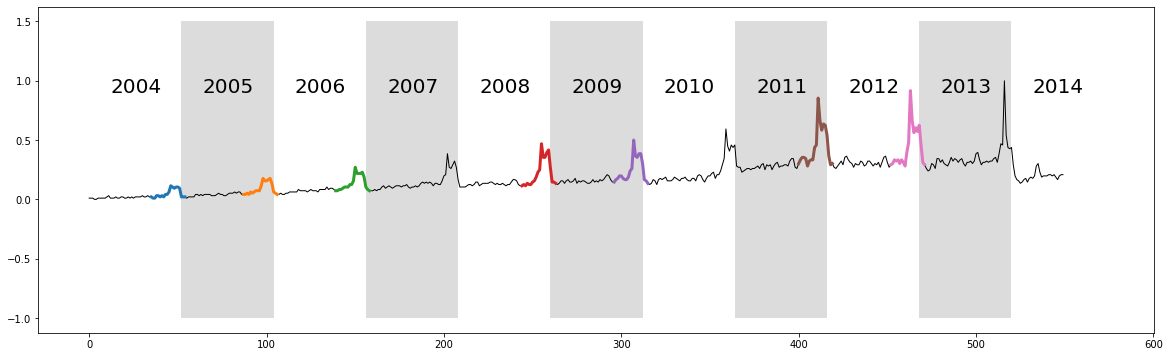

In [40]:
plt.plot(df['volume'], linewidth=1, color='black')
for i in range(unanchored_chain.shape[0]):
    y = df['volume'].iloc[unanchored_chain[i]:unanchored_chain[i]+m]
    x = y.index.values
    plt.plot(x, y, linewidth=3)
color = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, df.shape[0], 52)):
    plt.text(x+12, 0.9, str(2004+i), color="black", fontsize=20)
    rect = Rectangle((x, -1), 52, 2.5, facecolor=next(color))
    plt.gca().add_patch(rect)

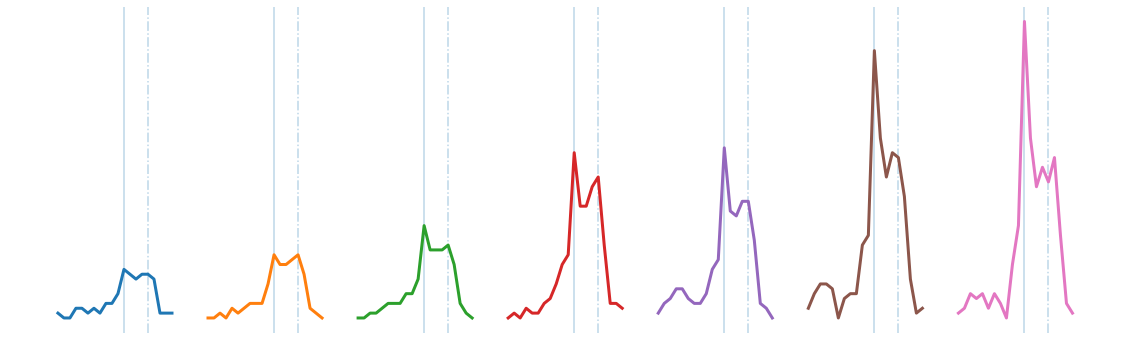

In [41]:
plt.axis('off')
for i in range(unanchored_chain.shape[0]):
    data = df['volume'].iloc[unanchored_chain[i]:unanchored_chain[i]+m].reset_index().values
    x = data[:, 0]
    y = data[:, 1]
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 11, alpha=0.3)
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 15, alpha=0.3, linestyle='-.')
    plt.plot(x-x.min()+(m+5)*i, y-y.min(), linewidth=3)

### Semantic Segmentation

https://stumpy.readthedocs.io/en/latest/Tutorial_Semantic_Segmentation.html

In [43]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
import urllib
import ssl
import io
import os

In [44]:
context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
url = 'https://sites.google.com/site/timeserieschain/home/TiltABP_210_25000.txt'
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
df = pd.read_csv(data, header=None)
df = df.reset_index().rename({'index': 'time', 0: 'abp'}, axis='columns')
df.describe()

time           abp
count  40000.00000  40000.000000
mean   19999.50000   4578.089500
std    11547.14972    867.552475
min        0.00000   2924.000000
25%     9999.75000   4008.000000
50%    19999.50000   4404.000000
75%    29999.25000   5132.000000
max    39999.00000   7296.000000

In [46]:
df.head()

time     abp
0     0  6832.0
1     1  6928.0
2     2  6968.0
3     3  6992.0
4     4  6980.0

In [47]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size

change_plot_size(20, 6, plt)

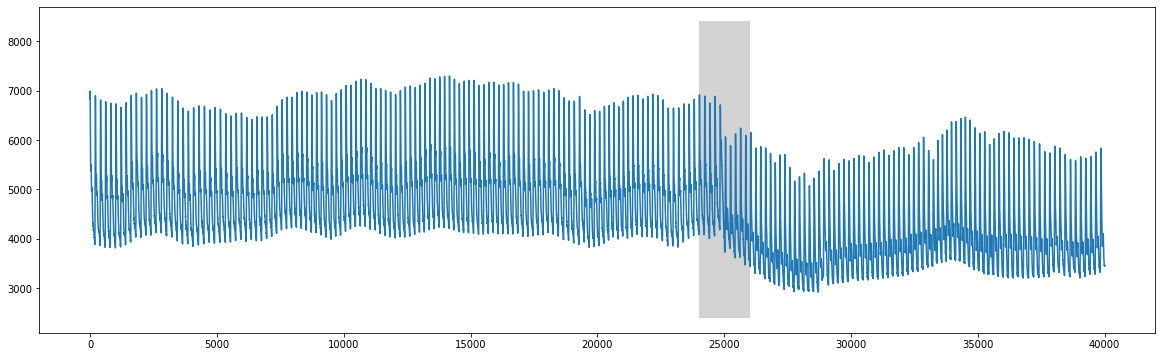

In [52]:
plt.plot(df['time'], df['abp'])
rect = Rectangle((24000,2400),2000,6000,facecolor='lightgrey')
plt.gca().add_patch(rect)

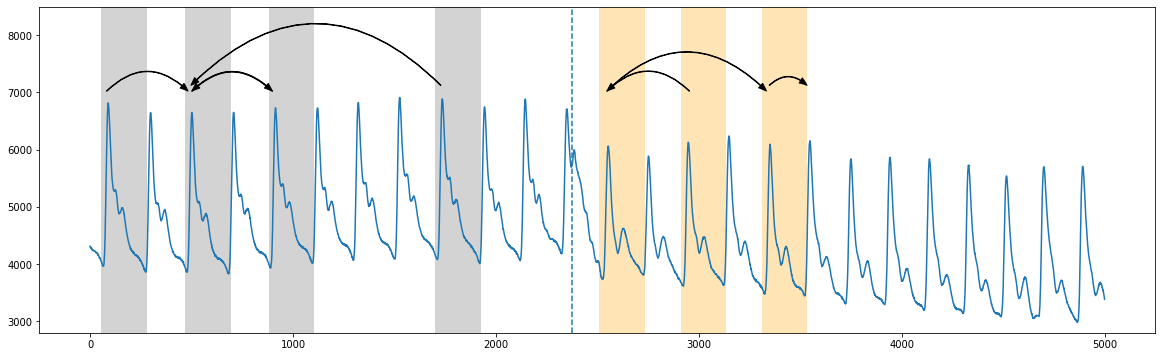

In [53]:
start = 25000 - 2500
stop = 25000 + 2500
abp = df.iloc[start:stop, 1]
plt.plot(range(abp.shape[0]), abp)
plt.ylim(2800, 8500)
plt.axvline(x=2373, linestyle="dashed")

style="Simple, tail_width=0.5, head_width=6, head_length=8"
kw = dict(arrowstyle=style, color="k")

# regime 1
rect = Rectangle((55,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((470,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((880,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((1700,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
arrow = FancyArrowPatch((75, 7000), (490, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((495, 7000), (905, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((905, 7000), (495, 7000), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((1735, 7100), (490, 7100), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)

# regime 2
rect = Rectangle((2510,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
rect = Rectangle((2910,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
rect = Rectangle((3310,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
arrow = FancyArrowPatch((2540, 7000), (3340, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((2960, 7000), (2540, 7000), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((3340, 7100), (3540, 7100), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)

In [54]:
m = 210
mp = stumpy.stump(abp, m=m)

In [55]:
L = 210
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)

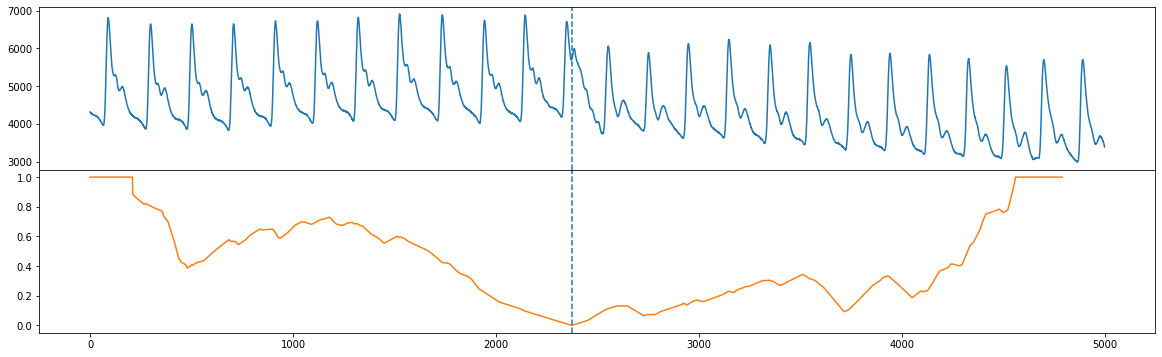

In [56]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")

In [57]:
cac_1d = stumpy._cac(mp[:, 3], L, bidirectional=False, excl_factor=1)  # This is for demo purposes only. Use floss() below!

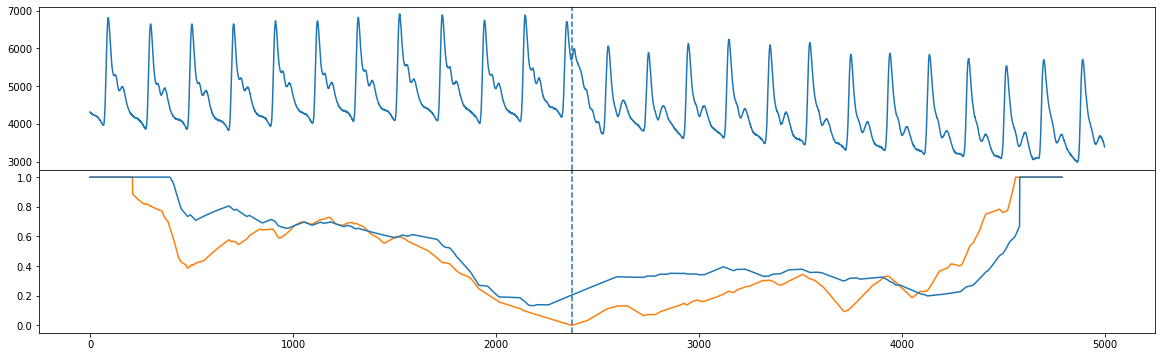

In [58]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(np.arange(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac_1d.shape[0]), cac_1d)

In [59]:
old_data = df.iloc[20000:20000+5000, 1].values  # This is well before the regime change has occurred

mp = stumpy.stump(old_data, m=m)

In [60]:
new_data = df.iloc[25000:25000+5000, 1].values

In [61]:
stream = stumpy.floss(mp, old_data, m=m, L=L, excl_factor=1)

In [62]:
windows = []
for i, t in enumerate(new_data):
    stream.update(t)

    if i % 100 == 0:
        windows.append((stream.T_, stream.cac_1d_))

In [63]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_xlim((0, mp.shape[0]))
axs[0].set_ylim((-0.1, max(np.max(old_data), np.max(new_data))))
axs[1].set_xlim((0, mp.shape[0]))
axs[1].set_ylim((-0.1, 1.1))

lines = []
for ax in axs:
    line, = ax.plot([], [], lw=2)
    lines.append(line)
line, = axs[1].plot([], [], lw=2)
lines.append(line)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(window):
    data_out, cac_out = window
    for line, data in zip(lines, [data_out, cac_out, cac_1d]):
        line.set_data(np.arange(data.shape[0]), data)
    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=windows, interval=100,
                               blit=True)

anim_out = anim.to_jshtml()
plt.close()  # Prevents duplicate image from displaying
if os.path.exists("None0000000.png"):
    os.remove("None0000000.png")  # Delete rogue temp file

HTML(anim_out)
# anim.save('/tmp/semantic.mp4')